In [17]:
from math import log10, sqrt 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import time
import random
from PIL import Image
import matplotlib.pyplot as plt
from numpy.linalg import svd
from ipywidgets import interact, interactive, interact_manual
import ipywidgets as widgets
from IPython.display import display

### Here we have parameters for Hillclimbing process.

In [18]:
n_colors = 3    # number of colors you want to find in image.
alpha = 40      # to have decreasing search radius.
img_path_input = 'km.jpg'
img_path_output = 'km1.jpg'
n_iterations = 50
n_initial_points = 2000
n_points = 10
stop_stuck = 7
alpha_dec = 0.9
final_points = {}
points_dic = {}
#to move elements after finding a better neighbour in.
points_dic_move = {}
points = []
points = np.asarray(points)

### Reading image and converting to numpy array, also we have transition array to do transition from a point to it's neighbours.

In [19]:
transition = [[1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1], [-1, 1, 1], [-1, 1, -1], [-1, -1, 1], [-1, -1, -1], [1, 1, 0], [1, 0, 1], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 0, 1], [-1, -1, 0], [-1, 0, -1], [-1, 0, 0], [0, -1, -1], [0, -1, 0], [0, 0, -1], [1, 0, -1], [0, 1, -1], [1, -1, 0], [-1, 1, 0], [0, -1, 1], [-1, 0, 1], [0, 0, 0]]
transition = np.asarray(transition)
# Converting image to numpy array
imgage = np.asarray(cv2.imread(img_path_input, 1))
img = cv2.resize(imgage, dsize=(15, 15), interpolation=cv2.INTER_CUBIC)


### Fitness function is made to calculate fitness of each point. fitness means how good the point (n_colors) is to coloring the whole image assigning closest color in n_colors to the pixle in image.

In [20]:
def fitness(point):
    fitness = 0
    for x in img:
        for i in x:
            min_ = 10000000000
            for j in point:
                min_ = min(np.linalg.norm(i - j), min_)
            fitness += min_
    return fitness

### Best_neighbour is a function to find best neighbour around the point (could be itself). for each point we have R G B and we have 3 modes for each (increas, stable, decrease), so 27 (3 *** 3) choices for each color and 27 **** n_colors neighbours in total. so we have to choose between them that which one could be the new point. (best fitness)

In [21]:
def Best_neighbour(point, transition):
    global alpha
    transition = transition * alpha
    temp_point = []
    for i in transition:
        for z in range(n_colors):
            for j in range(n_colors):
                temp = (i if z == j else np.asarray([0, 0, 0]))  + point[j]
                temp_point = np.concatenate((temp_point, temp), axis = 0)
    best = 1000000000
    worst = 0
    temp_point = np.reshape(temp_point, (3*3*3*n_colors,n_colors,3))
    for i in range(3*3*3*n_colors):
        done = 0
        fit = fitness(temp_point[i])
        if (fit < best):
            best = fit
            colors = temp_point[i]
        if ((i == 3*3*3*n_colors - 1) and (fit == best)):
            done = 1
            # means we can't find a better neighbour so we are stuck.
    return [best, colors, done]

### To color the image using point (n_colors) and calculating the fitness overall. fitness is calculated using Frobenius norm real color minus predicted one.

In [22]:
def make_image(point):
    fitness = 0
    new_img = np.copy(img)
    z = 0
    for f in range(len(new_img)):
        for i in range (len(new_img[f])):
            min_ = 10000
            for j in point:
                if (np.linalg.norm(new_img[f, i] - j) < min_):
                    min_ = np.linalg.norm(new_img[f, i] - j)
                    x = j
            new_img[f, i] = x
            z = z + 1
            fitness += min_
    return [new_img, fitness]

### We have n_initial_points random points at first, we calculate their fitness and choose top n_points of them to starte Hillclimbing.

In [23]:
for i in range(n_colors * n_initial_points):
    x = (random.random() * imgage.shape[0]) // 2 * 2
    x = int(x)
    y = (random.random() * imgage.shape[1]) // 2 * 2
    y = int(y)
    points = np.concatenate((points, imgage[x, y]), axis = 0)
points = np.reshape(points, (n_initial_points, n_colors, 3))
for i in points:
    points_dic[fitness(i)] = i

new_points = {}
for i in sorted(points_dic.keys())[:n_points]:
    new_points[i] = points_dic[i]
# points in dictionary with their fitness as key.
points_dic = new_points

### Here is a bit tricky, we have n_iterations and in each iteration we find the best neighbour for each point in points_dic and if we don't, we transfer it to final_points only if transition * alpha was below stop_stuck, else we hold it in a temporary list called points_dic_move among other new points (neighbours) to use in next iteration. 

In [24]:
for i in range(n_iterations):
    while (points_dic):
        l1 = len(final_points)
        l2 = len(points_dic)
        j = list(points_dic.keys())[0]
        x = Best_neighbour(points_dic[j], transition)
        if(x[2] == 1 and transition[0, 0] * alpha < stop_stuck):   # we stuck in one hill.
            final_points[j] = points_dic[j]
            points_dic.pop(j)
        else: # we have a better neighbour or we stuck and don't want to stop.
            points_dic.pop(j)
            points_dic_move[x[0]] = x[1]
        if (transition[0, 0] * alpha < stop_stuck and alpha_dec <= 0.92):
            alpha_dec = alpha_dec + 0.07
    # print(i + 1, " : ", len(final_points))
    points_dic = points_dic_move
    points_dic_move = {}
    if (transition[0, 0] * alpha > 1):
        alpha = alpha * alpha_dec
    # print("move =", transition[0, 0] * alpha)
img = np.asarray(cv2.imread(img_path_input, 1))
final_points.update(points_dic)
# print("img001")
# print(final_points[sorted(final_points.keys())[0]])


### Here we make the final image using the best point founded.

PSNR : 24.23768890594411
fitness : 17.2418938250744


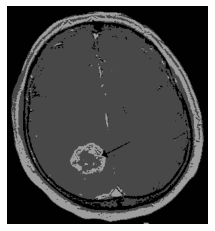

In [25]:
image = make_image(final_points[sorted(final_points.keys())[0]])
fitness = image[1]
image = image[0]
img1 = image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
print("PSNR :", cv2.PSNR(gray, gray1))
# print(cv2.PSNR(gray, gray1))
img1 = np.asarray(img1)
# print(img1)
print("fitness :", (fitness / np.size(img)) * 3)
# cv2.imwrite(img_path_output, img1)
# cv2.imshow('img1', img1)
# cv2.imshow('img', gray)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
cv2.imwrite(img_path_output, img1)
plt.imshow(img1)
plt.axis('off')
plt.show()

In [26]:
# replace images with the image you want to compress
images = {
    "image": np.asarray(cv2.imread(img_path_output, 1)),
    "image_org": np.asarray(cv2.imread(img_path_input, 1))
}

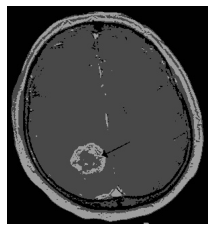

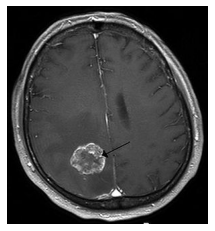

In [27]:
def show_images(img_name):
    plt.imshow(images[img_name])
    plt.axis('off')
    plt.show()
    

show_images('image')
show_images('image_org')

In [28]:
compressed_image = None

In [31]:
def compress_image(img_name, k):
    global compressed_image
    img = images[img_name]
    
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    ur,sr,vr = svd(r, full_matrices=False)
    ug,sg,vg = svd(g, full_matrices=False)
    ub,sb,vb = svd(b, full_matrices=False)
    rr = np.dot(ur[:,:k],np.dot(np.diag(sr[:k]), vr[:k,:]))
    rg = np.dot(ug[:,:k],np.dot(np.diag(sg[:k]), vg[:k,:]))
    rb = np.dot(ub[:,:k],np.dot(np.diag(sb[:k]), vb[:k,:]))
    
    rimg = np.zeros(img.shape)
    rimg[:,:,0] = rr
    rimg[:,:,1] = rg
    rimg[:,:,2] = rb
    
    for ind1, row in enumerate(rimg):
        for ind2, col in enumerate(row):
            for ind3, value in enumerate(col):
                if value < 0:
                    rimg[ind1,ind2,ind3] = abs(value)
                if value > 255:
                    rimg[ind1,ind2,ind3] = 255

    compressed_image = rimg.astype(np.uint8)
    plt.imshow(compressed_image)
    plt.axis('off')
    plt.show()
    gray0 = cv2.cvtColor(images['image_org'], cv2.COLOR_BGR2GRAY)
    gray1 = cv2.cvtColor(compressed_image, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(images['image'], cv2.COLOR_BGR2GRAY)
    print("PSNR with SVD:", cv2.PSNR(gray0, gray1))
    # print("PSNR", cv2.PSNR(gray0, gray2))
    # print("PS", cv2.PSNR(gray2, gray1))
    if (k == 30):
        cv2.imwrite("svd-.jpg", compressed_image)
    compressed_image = Image.fromarray(compressed_image)

In [32]:
interact(compress_image, img_name = "image", k = widgets.IntSlider(min=1, max=50, step=1, value=20))
interact(compress_image, img_name = "image_org", k = widgets.IntSlider(min=1, max=50, step=1, value=20))

interactive(children=(Text(value='image', description='img_name'), IntSlider(value=20, description='k', max=50…

interactive(children=(Text(value='image_org', description='img_name'), IntSlider(value=20, description='k', ma…

<function __main__.compress_image(img_name, k)>